In [1]:
import sys
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch
from torch import nn
from IPython import display
import torch.nn.functional as F

# Task 1

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])
batch_size=256
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          shuffle=True,batch_size=batch_size,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, batch_size=batch_size,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainiter = iter(trainloader)
testiter=iter(testloader)
images, labels = next(trainiter)
images1, labels1 = next(testiter)
print(type(trainloader))

print(images1.shape,labels1.shape)


<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([256, 3, 32, 32]) torch.Size([256])


# Task 2

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
      
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, k)
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.convs.append(conv)
            
        
        self.channel_check = nn.Sequential()
        if in_channels != out_channels:
            self.channel_check = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        a = self.fc(self.avg_pool(x).view(batch_size, num_channels))
        a = F.softmax(a, dim=1).view(batch_size, -1, 1, 1)
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)
        
        # Add the residual connection to the output
        res = self.channel_check(x)
        out += res
        return out

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = nn.Sequential(
            Block(3, 64),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            Block(64, 64),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Block(64, 128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            Block(128, 128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            Block(128, 128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Block(128, 256),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            Block(256, 256),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            Block(256, 256),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Block(256, 512),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            Block(512, 512),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            Block(512, 512),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.backbone(x)          
        x = self.classifier(x)        
        return x




In [5]:
def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')     

model = Model()

model.apply(init_weights);



# Task 3

In [6]:
# Creare your loss here. Use Cross Entropy loss:
loss = nn.CrossEntropyLoss()
lr, wd = 0.001, 0.0005
# Creare your optimizer here. Use SGD with weight decay wd and learning rate lr.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (backbone): Sequential(
    (0): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=3, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (channel_check): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=64, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (channel_check): Sequential()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

# Task 4

In [7]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.


In [8]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
def evaluate_accuracy(net, data_iter,device): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X,y=X.to(device),y.to(device)

        metric.add(accuracy(net(X), y), y.numel())
    if(metric[1]==0):
      return 0
    else:
      return metric[0] / metric[1]

In [10]:
evaluate_accuracy(model, testloader,device)

0.0811

In [11]:
def train_epoch_ch3(net, train_iter, loss, optimizer,device, batch_size=batch_size, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        X,y=X.to(device),y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    if(metric[2]==0):
      return 0,0
    else:
      return metric[0] / metric[2], metric[1] / metric[2]

In [12]:
import matplotlib.pyplot as plt

def plot_train_test(net, train_iter, test_iter, loss, num_epochs, optimizer,device): 
    """Train a model."""
    train_loss_list=[]
    train_acc_list=[]
    test_acc_list=[]
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer,device)
        test_acc = evaluate_accuracy(net, test_iter,device)
        train_loss, train_acc=train_metrics
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)


        print("training loss for epoch",epoch+1,"is:",train_loss)
        print("training accuracy for epoch", epoch+1,"is:", train_acc)
        print("test accuracy for epoch",epoch+1,"is:", test_acc)


    plt.figure()
    plt.plot(train_loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    plt.figure()
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(test_acc_list, label='test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()




# Task 5

training loss for epoch 1 is: 1.6010638765716552
training accuracy for epoch 1 is: 0.42388
test accuracy for epoch 1 is: 0.5296
training loss for epoch 2 is: 1.092179538154602
training accuracy for epoch 2 is: 0.61142
test accuracy for epoch 2 is: 0.6498
training loss for epoch 3 is: 0.916343949546814
training accuracy for epoch 3 is: 0.68448
test accuracy for epoch 3 is: 0.721
training loss for epoch 4 is: 0.6941771662330627
training accuracy for epoch 4 is: 0.76358
test accuracy for epoch 4 is: 0.7675
training loss for epoch 5 is: 0.5717282534217835
training accuracy for epoch 5 is: 0.80468
test accuracy for epoch 5 is: 0.7939
training loss for epoch 6 is: 0.4916625495529175
training accuracy for epoch 6 is: 0.83006
test accuracy for epoch 6 is: 0.8057
training loss for epoch 7 is: 0.4258752038192749
training accuracy for epoch 7 is: 0.85266
test accuracy for epoch 7 is: 0.8238
training loss for epoch 8 is: 0.3721521228790283
training accuracy for epoch 8 is: 0.87088
test accuracy fo

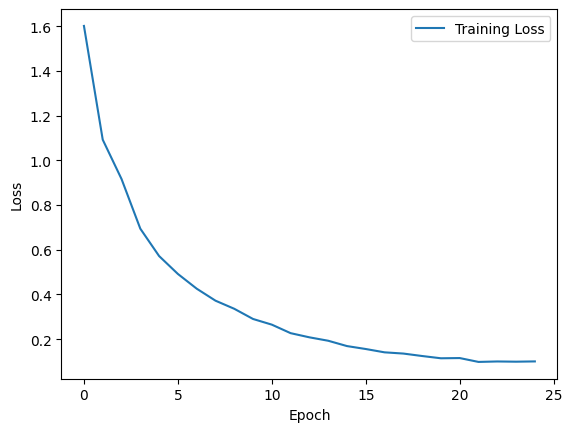

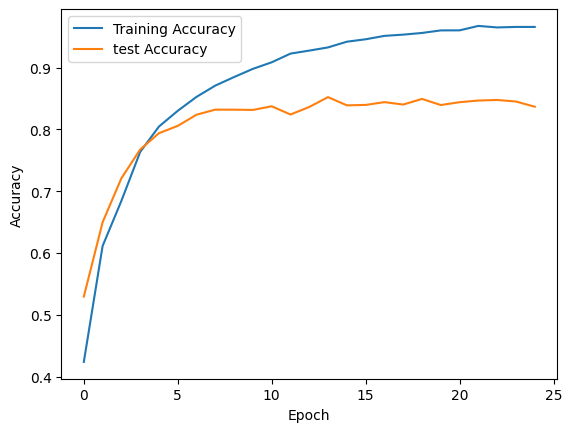

In [13]:
num_epochs = 25
plot_train_test(model, trainloader, testloader, loss, num_epochs, optimizer,device)